<a href="https://colab.research.google.com/github/Wooshaw/ESE_527_Project/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import datetime as dt
import copy
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
def compute_rsi(data, window=14):
    delta = data.diff()
    delta = delta.dropna()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    avg_gain = up.rolling(window=window, min_periods=1).mean()
    avg_loss = -down.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def norm(a, b, result):

    min_vals = np.min(result, 0)
    max_vals = np.max(result, 0)
    result - min_vals
    # Avoid division by zero in case max and min are the same
    result = a + ((result - min_vals) / (max_vals - min_vals + np.finfo(float).eps)) * (b - a)

    return result

In [ ]:
df_BRK = yf.Ticker("BRK-A").history(period="max")

df_BRK.reset_index(inplace=True) # Make date no longer an Index
df_BRK['1d_Close'] = df_BRK['Close'].shift(1)
df_BRK['3d_Close'] = df_BRK['Close'].shift(3)
df_BRK['7d_Close'] = df_BRK['Close'].shift(7)

df_BRK['RSI'] = compute_rsi(df_BRK['Close'])

df_BRK['SMA'] = df_BRK['Close'].rolling(window=20).mean()
df_BRK['STD'] = df_BRK['Close'].rolling(window=20).std()
df_BRK['Upper_BB'] = df_BRK['SMA'] + (df_BRK['STD'] * 2)
df_BRK['Lower_BB'] = df_BRK['SMA'] - (df_BRK['STD'] * 2)
df_BRK = df_BRK.iloc[19:,:]
df_BRK = df_BRK.drop(['Date'], axis=1)

df_BRK['Target'] = df_BRK['Close']
df_BRK = df_BRK.drop(['Close'], axis=1)

df_BRK.head()

,Open,High,Low,Volume,Dividends,Stock Splits,1d_Close,3d_Close,7d_Close,RSI,SMA,STD,Upper_BB,Lower_BB,Target
19,260.0,275.0,255.0,20000,0.0,0.0,260.0,265.0,260.0,20.000000,270.50,12.343760,295.187521,245.812479,255.0
20,255.0,265.0,245.0,20000,0.0,0.0,255.0,260.0,260.0,14.285714,268.25,12.698425,293.646850,242.853150,245.0
21,245.0,245.0,245.0,0,0.0,0.0,245.0,260.0,265.0,14.285714,266.00,12.628289,291.256578,240.743422,245.0
22,255.0,275.0,255.0,10000,0.0,0.0,245.0,255.0,265.0,33.333333,264.25,11.502288,287.254576,241.245424,255.0
23,255.0,275.0,255.0,20000,0.0,0.0,255.0,245.0,265.0,33.333333,262.50,9.933993,282.367985,242.632015,255.0


In [ ]:
rolling_obj = df_BRK.rolling(window=15)
arrays = [window.values for window in rolling_obj if len(window) == 15]
result = np.array(arrays)

In [ ]:
input_feature = []
label = []
key = []

for i in range(0, result.shape[0]):
    trans = result[i]
    target = trans[:, -1]
    feature = trans[:-1, :]
    feature = norm(0, 1, feature)
    min_t = target[:-1].min()
    max_t = target[:-1].max()
    if max_t != min_t and np.isnan(feature).any() == False:
        t = (target[-1]-min_t)/(max_t-min_t)
        input_feature.append(feature)
        label.append(t)
        key.append([min_t, max_t])

input_feature = np.array(input_feature)
label = np.array(label)
key = np.array(key)

In [ ]:
input_feature = torch.tensor(input_feature, dtype=torch.float32)
label = torch.tensor(label, dtype=torch.float32)

train_size = int(input_feature.shape[0] * 0.8)

train_feature, train_label = input_feature[:train_size], label[:train_size]
test_feature, test_label, test_key = input_feature[train_size:], label[train_size:], key[train_size:]

print(train_feature.shape, train_label.shape)
train_dataset = TensorDataset(train_feature, train_label)
test_dataset = TensorDataset(test_feature, test_label)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
inf_loader = DataLoader(test_dataset, batch_size=1)

torch.Size([8697, 14, 15]) torch.Size([8697])


# Model Building
## 1. Baseline LSTM model
- Baseline Long Short-Term Memory (LSTM) model that will serve as a reference point to assess the efficacy of our current preprocessing pipeline.

In [ ]:
class StockPriceLSTM(nn.Module):
    def __init__(self):
        super(StockPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=15, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)
torch.cuda.set_device(0)

model = StockPriceLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(100):
    total_loss = 0
    for inputs, targets in train_loader:
        outputs = model(inputs.to(device))
#         print(targets)
        loss = criterion(outputs, targets.view(-1,1).to(device))
#         print(loss.item())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

    with torch.no_grad():
        total_loss = 0
        for inputs, targets in test_loader:
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.view(-1,1).to(device))
            total_loss += loss.item()
        print(f'Test Loss: {total_loss / len(test_loader)}')

Epoch 1, Loss: 0.2671636549810715
Test Loss: 0.20062819035614238
Epoch 2, Loss: 0.19083799469722984
Test Loss: 0.1311656524810721
Epoch 3, Loss: 0.13721429300494492
Test Loss: 0.09945668964920674
Epoch 4, Loss: 0.13516373911817722
Test Loss: 0.1135098447694498
Epoch 5, Loss: 0.1278817176216227
Test Loss: 0.09989627565750304
Epoch 6, Loss: 0.12353408830377328
Test Loss: 0.09778506845674094
Epoch 7, Loss: 0.11879627712016158
Test Loss: 0.0930485390674542
Epoch 8, Loss: 0.11609372980070903
Test Loss: 0.09580484542119153
Epoch 9, Loss: 0.11570006570614436
Test Loss: 0.08608449338113561
Epoch 10, Loss: 0.11834973535116981
Test Loss: 0.0807631765218342
Epoch 11, Loss: 0.1174100288463866
Test Loss: 0.08989652476328261
Epoch 12, Loss: 0.11384591876583941
Test Loss: 0.08894521978628986
Epoch 13, Loss: 0.11721218226011842
Test Loss: 0.08222268346477957
Epoch 14, Loss: 0.11349545656155575
Test Loss: 0.0925981387605562
Epoch 15, Loss: 0.11120933409341995
Test Loss: 0.08124079215614234
Epoch 16, Lo

In [ ]:
with torch.no_grad():
    pred = []
    real = []
    for inputs, targets in inf_loader:
        outputs = model(inputs.to(device))
        pred.append(outputs[0,0].detach().to("cpu").item())
        real.append(targets[0].detach().to("cpu").item())

inv_pred = []
inv_real = []
for i in range(0, len(pred)):
    value = pred[i]*(test_key[i,0]-test_key[i,1])+test_key[i,1]
    inv_pred.append(value)
    value = real[i]*(test_key[i,0]-test_key[i,1])+test_key[i,1]
    inv_real.append(value)

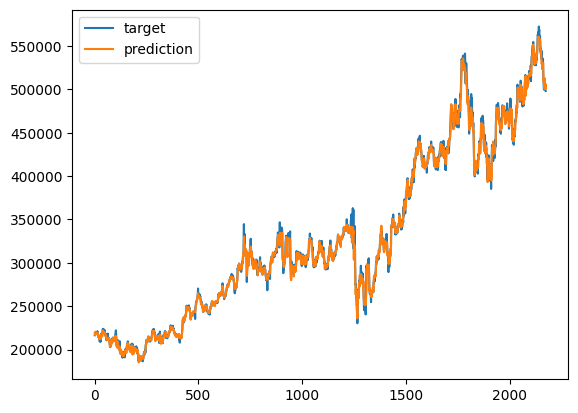

In [ ]:
x = range(len(inv_pred))
plt.plot(x,inv_real, label="target")
plt.plot(x,inv_pred, label="prediction")
plt.legend()
plt.show()

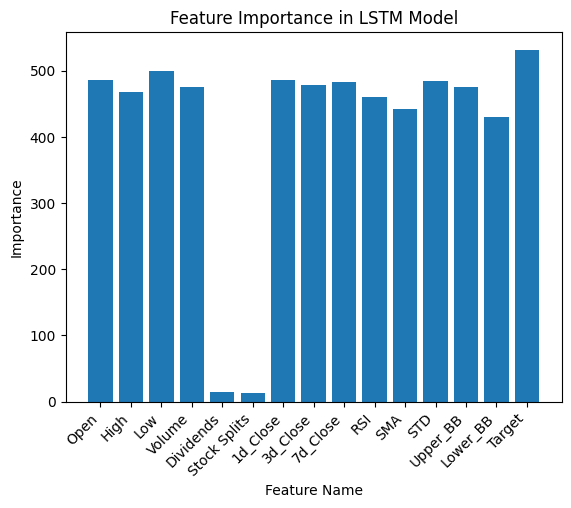

In [ ]:
# Assuming your LSTM input size is 15
input_size = 15

# Get the feature names from your dataset
feature_names = df_BRK.columns[0:]  # Exclude the last column (Target)

# Get the weights from the first layer of the LSTM
lstm_weights = model.lstm.weight_ih_l0.detach().cpu().numpy()

# Calculate the importance of each feature by summing the absolute values of the weights
feature_importance = np.sum(np.abs(lstm_weights), axis=0)

# Plot the feature importance with feature names
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance in LSTM Model')
plt.xlabel('Feature Name')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming df_BRK is your DataFrame with features and target
# X should contain all your features (excluding the target column)
# y should be your target column

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(df_BRK.drop(columns=['Target'])), columns=df_BRK.columns[:-1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, df_BRK['Target'], test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Initialize RFE with the linear regression model
# Choose the number of features you want to keep (adjust based on your requirements)
num_features_to_keep = 10
rfe = RFE(model, n_features_to_select=num_features_to_keep)

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_imputed.columns[rfe.support_]

# Train a linear regression model using only the selected features
model.fit(X_train[selected_features], y_train)

# Make predictions on the test set
y_pred = model.predict(X_test[selected_features])

# Display the selected features
print('Selected Features:', selected_features)


Selected Features: Index(['Open', 'High', 'Low', '1d_Close', '3d_Close', '7d_Close', 'RSI', 'SMA',
       'Upper_BB', 'Lower_BB'],
      dtype='object')


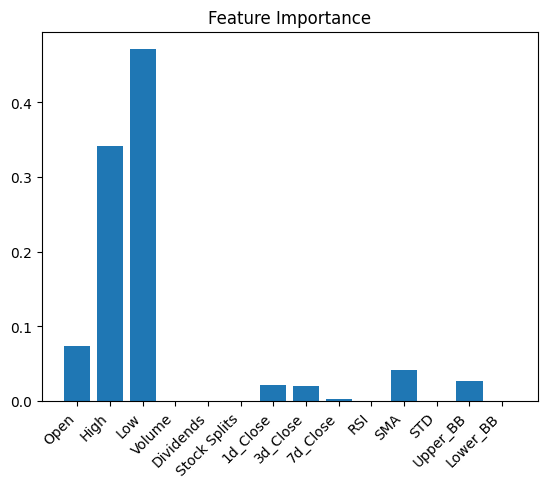

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
feature_importances = model.feature_importances_
plt.bar(X_train.columns, feature_importances)
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

# Assuming you have your data and model defined (similar to your previous code)

# Define a function to train and evaluate the model for a set of hyperparameters
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.view(-1, 1).to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        with torch.no_grad():
            val_loss = 0
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                val_loss += criterion(outputs, targets.view(-1, 1).to(device)).item()

        print(f'Epoch {epoch + 1}, Training Loss: {total_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}')

# Define a function to perform hyperparameter sensitivity analysis
def hyperparameter_sensitivity_analysis(model, train_loader, val_loader, hyperparameter_grid, criterion, optimizer):
    results = []

    for hyperparameters in ParameterGrid(hyperparameter_grid):
        print(f"\nTraining model with hyperparameters: {hyperparameters}")

        # Set hyperparameters for the model
        for key, value in hyperparameters.items():
            setattr(model, key, value)

        # Train and evaluate the model
        train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)

        # Evaluate on validation set
        with torch.no_grad():
            val_losses = []
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                val_losses.append(mean_squared_error(targets.cpu().numpy(), outputs.cpu().numpy()))

            average_val_loss = np.mean(val_losses)
            results.append((hyperparameters, average_val_loss))
            print(f'Average Validation Loss: {average_val_loss}')

    # Return the results
    return results

# Set up your data and model (similar to your previous code)
# ...

# Set up hyperparameter grid
hyperparameter_grid = {
    'hidden_size': [50, 100],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.0001]
    # Add other hyperparameters to explore
}

# Create an instance of your LSTM model
model = StockPriceLSTM().to(device)

# Set up your criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Split your data into training and validation sets
# ...

# Create DataLoader instances for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32)

# Perform hyperparameter sensitivity analysis
results = hyperparameter_sensitivity_analysis(model, train_loader, val_loader, hyperparameter_grid, criterion, optimizer)

# Print the results
for hyperparameters, average_val_loss in results:
    print(f"\nHyperparameters: {hyperparameters}")
    print(f"Average Validation Loss: {average_val_loss}")



Training model with hyperparameters: {'hidden_size': 50, 'learning_rate': 0.001, 'num_layers': 1}
Epoch 1, Training Loss: 0.2649090287330396, Validation Loss: 0.16251400047365358
Epoch 2, Training Loss: 0.17204100055181804, Validation Loss: 0.11882340595783557
Epoch 3, Training Loss: 0.14706020285923252, Validation Loss: 0.10609262880376157
Epoch 4, Training Loss: 0.13309156811138725, Validation Loss: 0.0931455970139188
Epoch 5, Training Loss: 0.12115652496269082, Validation Loss: 0.08518344489857554
Epoch 6, Training Loss: 0.1133706921382862, Validation Loss: 0.08117231469163123
Epoch 7, Training Loss: 0.10991966560729505, Validation Loss: 0.07950856213403099
Epoch 8, Training Loss: 0.10863173166837763, Validation Loss: 0.08004339543335579
Epoch 9, Training Loss: 0.10742083200089195, Validation Loss: 0.07863635230152045
Epoch 10, Training Loss: 0.10704300662173945, Validation Loss: 0.07801926678375286
Epoch 11, Training Loss: 0.10638127265059773, Validation Loss: 0.07772590324063511
